In [1]:
# import all libraries you need here
import pandas as pd
import numpy as np
import pathlib as pl
import harmonypy as hm
import os

import scanpy as sc

In [2]:
random_seed = 42
np.random.seed(random_seed)
sc.settings.seed = random_seed

# Step 0: Load the data

In [3]:
path_data_train = pl.Path("data/train_data")
path_data_test = pl.Path("data/test_data")

In [4]:
train_bulk = pd.read_csv(path_data_train / "train_bulk.csv",index_col=0)
train_bulk_trueprops = pd.read_csv(path_data_train / "train_bulk_trueprops.csv",index_col=0)
train_adata = sc.read_h5ad(path_data_train / "train_adata.h5ad")
test_adata = sc.read_h5ad(path_data_test / "test_adata.h5ad")
test_bulk = pd.read_csv(path_data_test / "test_bulk.csv",index_col=0)


In [5]:
print(f"Number of patients to deconvolve: {train_bulk.shape[1]}")
print(f"Number of genes in dataset: {train_bulk.shape[0]}")

Number of patients to deconvolve: 12
Number of genes in dataset: 7725


In [6]:
print(train_adata.obs.shape)
train_adata.obs.head()

(32374, 10)


,Sample,Patient,Tumor status,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,highLevelType,chemo
AAACCCAAGGAGACCT-1_1,s1,P1,Tumor,991,991,2156.0,131.0,6.076067,T,post
AAACCCAGTAGACAGC-1_1,s1,P1,Tumor,1063,1063,2485.0,84.0,3.380282,T,post
AAACCCAGTAGATCGG-1_1,s1,P1,Tumor,855,855,1993.0,87.0,4.365278,T,post
AAACCCAGTATCACCA-1_1,s1,P1,Tumor,1002,1002,2147.0,139.0,6.474150,B,post
AAACCCAGTTGGAGGT-1_1,s1,P1,Tumor,958,958,2438.0,108.0,4.429861,T,post


In [7]:
train_adata.var.head()

,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
Unnamed: 0,,,,,,
NOC2L,6735,False,6735,0.143681,87.143757,7527.0
HES4,8287,False,8287,0.330635,84.181190,17321.0
ISG15,19640,False,19640,0.871934,62.509783,45678.0
TNFRSF18,12021,False,12021,0.682345,77.053467,35746.0
TNFRSF4,7880,False,7880,0.484510,84.958100,25382.0


(7725, 6)


<Axes: >

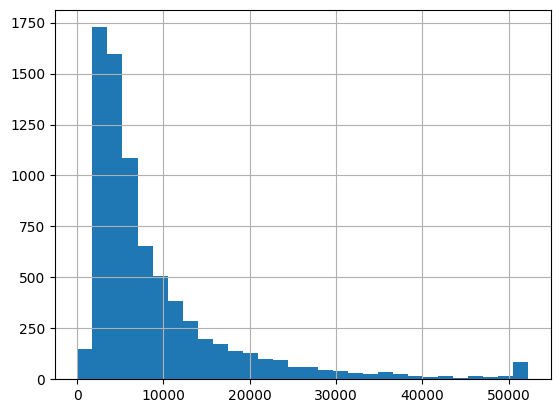

In [8]:
print(train_adata.var.shape)
train_adata.var["n_cells"].hist(bins=30)

In [9]:
train_adata.shape

(32374, 7725)

In [10]:
print(train_bulk.shape)
train_bulk.head()

(7725, 12)


,s1_0,s1_1,s2_0,s2_1,s3_0,s3_1,s4_0,s4_1,s7_0,s7_1,s8_0,s8_1
Unnamed: 0,,,,,,,,,,,,
NOC2L,201.0,226.0,133.0,150.0,167.0,176.0,235.0,190.0,147.0,123.0,143.0,132.0
HES4,470.0,532.0,874.0,924.0,332.0,352.0,661.0,463.0,432.0,349.0,333.0,363.0
ISG15,852.0,918.0,1995.0,2116.0,1221.0,1282.0,1649.0,1152.0,957.0,847.0,717.0,768.0
TNFRSF18,712.0,870.0,1753.0,1925.0,352.0,289.0,2069.0,1357.0,446.0,367.0,821.0,844.0
TNFRSF4,550.0,472.0,920.0,1207.0,211.0,240.0,940.0,943.0,310.0,278.0,655.0,834.0


In [11]:
print(f"Number of cells in the train set {train_adata.n_obs}")
for spl in train_adata.obs.Sample.unique():
    print(f"Number of cells for {spl} is {train_adata[train_adata.obs.Sample==spl].n_obs}")

Number of cells in the train set 32374
Number of cells for s1 is 6821
Number of cells for s2 is 4555
Number of cells for s3 is 5166
Number of cells for s4 is 5607
Number of cells for s7 is 4471
Number of cells for s8 is 5754


In [12]:
print(f"There are {train_adata.obs.highLevelType.nunique()} different cell types in the dataset")
print(f"The different cells types are {train_adata.obs.highLevelType.unique().astype(str)}")

There are 9 different cell types in the dataset
The different cells types are ['T' 'B' 'Plasmablast' 'Fibroblast' 'Mast' 'Myeloid' 'NK' 'Myofibroblast'
 'Endothelial']


In [13]:
print(f"Number of cells in the test set {test_adata.n_obs}")
for spl in test_adata.obs.Sample.unique():
    print(f"Number of cells for {spl} is {test_adata[test_adata.obs.Sample==spl].n_obs}")

Number of cells in the test set 18616
Number of cells for s5 is 6020
Number of cells for s6 is 5530
Number of cells for s9 is 3336
Number of cells for s10 is 3730


In [14]:
train_bulk.head()

,s1_0,s1_1,s2_0,s2_1,s3_0,s3_1,s4_0,s4_1,s7_0,s7_1,s8_0,s8_1
Unnamed: 0,,,,,,,,,,,,
NOC2L,201.0,226.0,133.0,150.0,167.0,176.0,235.0,190.0,147.0,123.0,143.0,132.0
HES4,470.0,532.0,874.0,924.0,332.0,352.0,661.0,463.0,432.0,349.0,333.0,363.0
ISG15,852.0,918.0,1995.0,2116.0,1221.0,1282.0,1649.0,1152.0,957.0,847.0,717.0,768.0
TNFRSF18,712.0,870.0,1753.0,1925.0,352.0,289.0,2069.0,1357.0,446.0,367.0,821.0,844.0
TNFRSF4,550.0,472.0,920.0,1207.0,211.0,240.0,940.0,943.0,310.0,278.0,655.0,834.0


# Step 1: Deconvolve the data

In [99]:
from sklearn.svm import NuSVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from scipy.optimize import nnls
# import warnings
# warnings.filterwarnings('ignore')

CELL_ORDER = ['T', 'Endothelial', 'Fibroblast', 'Plasmablast', 'B', 'Myofibroblast', 'NK', 'Myeloid', 'Mast']  

# OPTIONAL: Improved deconvolution with marker gene selection
def select_marker_genes(adata, n_genes=500, method='variance', min_expression_rate=0.1):
    """
    Select marker genes for deconvolution, accounting for dropout.
    
    Parameters:
    - adata: AnnData object with single-cell data
    - n_genes: Number of marker genes to select
    - method: 'variance' for highly variable genes, or 'differential' for DE genes
    - min_expression_rate: Minimum fraction of cells expressing the gene (dropout filter)
    """
    # sc.pp.filter_genes(adata, min_cells=3)

    # First filter by dropout rate - keep genes expressed in at least min_expression_rate of cells
    expression_rate = (adata.X > 0).sum(axis=0).A1 / adata.n_obs
    expressed_genes = adata.var_names[expression_rate >= min_expression_rate]
    print(f"  After dropout filter (>{min_expression_rate*100}% cells): {len(expressed_genes)} genes")
    
    # Create filtered adata
    adata_filtered = adata[:, expressed_genes].copy()
    # adata_filtered = adata.copy()
    
    if method == 'variance':
        # Select highly variable genes from dropout-filtered set
        sc.pp.highly_variable_genes(adata_filtered, n_top_genes=min(n_genes, adata_filtered.n_vars), 
                                    flavor='seurat_v3')
        marker_genes = adata_filtered.var_names[adata_filtered.var.highly_variable]
    elif method == 'differential':
        # Find marker genes using differential expression
        sc.tl.rank_genes_groups(adata_filtered, groupby='highLevelType', method='wilcoxon')
        # Get top markers for each cell type
        marker_genes = []
        n_per_type = n_genes // adata_filtered.obs.highLevelType.nunique()
        for ct in adata_filtered.obs.highLevelType.unique():
            markers = sc.get.rank_genes_groups_df(adata_filtered, group=ct).head(n_per_type)
            marker_genes.extend(markers['names'].tolist())
        marker_genes = list(set(marker_genes))  # Remove duplicates
    
    return marker_genes


# Step 1: Create reference matrix with multiple strategies
def create_reference_matrix(adata, cell_type_col='highLevelType', method='mean', batch_norm=True, batch_key='Sample'):
    """
    Create a reference gene expression matrix from single-cell data.
    
    Parameters:
    - method: 'mean' (default), 'median', 'trimmed_mean'
    """
    adata_corrected = adata.copy()

    if batch_norm:
        
        # Normalize
        sc.pp.normalize_total(adata_corrected, target_sum=1e4)
        sc.pp.log1p(adata_corrected)
        
        # ComBat batch correction (operates on log-normalized data)
        sc.pp.combat(adata_corrected, key=batch_key)

    # sc.pp.filter_cells(adata, min_genes=500)
    # sc.pp.filter_cells(adata, max_genes=3000)


    cell_types = sorted(adata.obs[cell_type_col].unique())
    reference = pd.DataFrame(
        index=adata.var_names,
        columns=cell_types
    )
    
    for ct in cell_types:
        mask = adata_corrected.obs[cell_type_col] == ct
        cell_data = adata_corrected[mask].X
        # Standard methods without dropout correction
        cell_data_array = cell_data.toarray() if hasattr(cell_data, 'toarray') else cell_data
        l = len(cell_data_array)
        if method == 'max':
            reference[ct] = np.max(cell_data_array, axis=0)
        elif method == 'mean':
            reference[ct] = np.mean(cell_data_array, axis=0)
        elif method == 'median':
            reference[ct] = np.median(cell_data_array, axis=0)
        elif method == 'trimmed_mean':
            from scipy import stats
            reference[ct] = stats.trim_mean(cell_data_array, 0.1, axis=0)
        elif method == 'active_only':
            mask = cell_data_array > 0
            reference[ct] = cell_data_array[mask].sum(axis=0) / mask.sum(axis=0)
    return reference[CELL_ORDER]


# Improved deconvolution with data preprocessing
def deconvolve(bulk_data: pd.DataFrame, reference_matrix: pd.DataFrame, method='nnls'):
    """
    Deconvolve bulk RNA-seq data with multiple method options.
    
    Parameters:
    - bulk_data: DataFrame with genes as rows, samples as columns
    - reference_matrix: DataFrame with genes as rows, cell types as columns
    - method: 'nnls', 'qp' (quadratic programming), 'robust'
    - log_transform: Apply log transformation before deconvolution
    
    Returns:
    - DataFrame with cell types as rows, samples as columns (proportions)
    """
    # Find common genes
    common_genes = bulk_data.index.intersection(reference_matrix.index)
    print(f"Using {len(common_genes)} common genes for deconvolution")
    
    # Subset to common genes
    bulk_subset = bulk_data.loc[common_genes].copy()
    ref_subset = reference_matrix.loc[common_genes].copy()
    
    
    # Initialize results
    proportions = pd.DataFrame(
        index=ref_subset.columns, # cell types
        columns=bulk_subset.columns # samples
    )

    for sample in bulk_subset.columns:
        # Deconvolve each sample
        bulk_profile = bulk_subset[sample].to_numpy()
        ref_matrix = ref_subset.to_numpy()
        
        props, residual = nnls(ref_matrix, bulk_profile)
        
        # Normalize to sum to 1
        props = props / props.sum() if props.sum() > 0 else np.ones(len(props)) / len(props)
        proportions[sample] = props

    
    if method=='nmf':
        W = proportions.to_numpy().T.astype(np.float32, copy=True, order='C')
        H = ref_subset.to_numpy().T.astype(np.float32, copy=True, order='C')
        X = bulk_subset.to_numpy().T.astype(np.float32, copy=True, order='C')

        # print(H.flags, W.flags, X.flags)
        W = NMF(init='custom', max_iter=10000).fit_transform(X, W=W, H=H).T

        for i in range(W.shape[1]):
            col = W[:, i]
            col = col / col.sum() if col.sum() > 0 else np.ones(len(col)) / len(col)
            proportions.iloc[:, i] = col

        
    return proportions.loc[CELL_ORDER]


# Create reference from training data with dropout correction
reference = create_reference_matrix(train_adata, cell_type_col='highLevelType', 
                                   method='trimmed_mean', batch_norm=False)
print(f"Reference shape: {reference.shape}")
print(f"Cell types: {list(reference.columns)}")

# Try with marker genes
adata_copy = train_adata.copy()
# 4144
marker_genes = select_marker_genes(adata_copy, n_genes=5000, method='variance', min_expression_rate=.1)
print(f"Selected {len(marker_genes)} marker genes")
reference_markers = reference.loc[marker_genes]

train_props_pred = deconvolve(train_bulk, reference_markers, method='nnls')
print(f"Predicted proportions shape: {train_props_pred.shape}")

train_props_pred

Reference shape: (7725, 9)
Cell types: ['T', 'Endothelial', 'Fibroblast', 'Plasmablast', 'B', 'Myofibroblast', 'NK', 'Myeloid', 'Mast']
  After dropout filter (>10.0% cells): 4149 genes
Selected 4149 marker genes
Using 4149 common genes for deconvolution
Predicted proportions shape: (9, 12)


,s1_0,s1_1,s2_0,s2_1,s3_0,s3_1,s4_0,s4_1,s7_0,s7_1,s8_0,s8_1
T,0.270016,0.009028,0.304782,0.369413,0.000000,0.065037,0.564386,0.648157,0.000000,0.000000,0.000000,0.000000
Endothelial,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049753,0.071261,0.067098,0.096031,0.000000,0.000000
Fibroblast,0.000000,0.000000,0.000000,0.000000,0.234342,0.245308,0.088089,0.111393,0.063941,0.027963,0.002645,0.000000
Plasmablast,0.018407,0.232638,0.000273,0.016045,0.170025,0.003148,0.004306,0.032137,0.085575,0.101392,0.062481,0.029167
B,0.274880,0.318552,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.265643,0.369269,0.358124,0.282497
Myofibroblast,0.000000,0.000000,0.234618,0.291417,0.161537,0.147905,0.000000,0.000000,0.290513,0.225899,0.263602,0.317798
NK,0.000000,0.000000,0.019788,0.000000,0.371296,0.511815,0.221641,0.000000,0.171703,0.079106,0.227765,0.275901
Myeloid,0.153029,0.066561,0.000000,0.000000,0.062800,0.026788,0.071825,0.106232,0.055526,0.100340,0.085384,0.094636
Mast,0.283668,0.373221,0.440540,0.323126,0.000000,0.000000,0.000000,0.030820,0.000000,0.000000,0.000000,0.000000


In [100]:
train_bulk_trueprops.loc[CELL_ORDER]

,s1_0,s1_1,s2_0,s2_1,s3_0,s3_1,s4_0,s4_1,s7_0,s7_1,s8_0,s8_1
highLevelType,,,,,,,,,,,,
T,0.568586,0.359160,0.489681,0.570671,0.458667,0.657534,0.340176,0.395770,0.583417,0.519878,0.366071,0.554028
Endothelial,0.024165,0.022324,0.030019,0.028269,0.009778,0.008864,0.017595,0.024169,0.049950,0.084608,0.041071,0.045187
Fibroblast,0.105188,0.130663,0.065666,0.038869,0.048000,0.095085,0.079912,0.109768,0.097902,0.045872,0.076786,0.084479
Plasmablast,0.013504,0.174655,0.001876,0.053004,0.108444,0.004029,0.000733,0.032226,0.073926,0.081549,0.042857,0.010806
B,0.049751,0.079448,0.089118,0.075088,0.040000,0.052377,0.074780,0.046324,0.029970,0.171254,0.222321,0.053045
Myofibroblast,0.041222,0.038083,0.030019,0.093640,0.061333,0.075745,0.075513,0.084592,0.011988,0.012232,0.073214,0.080550
NK,0.073205,0.136573,0.117261,0.055654,0.168889,0.058018,0.320381,0.129909,0.126873,0.014271,0.152679,0.143418
Myeloid,0.064677,0.021011,0.030019,0.079505,0.064000,0.029009,0.081378,0.135952,0.007992,0.051988,0.001786,0.014735
Mast,0.059701,0.038083,0.146341,0.005300,0.040889,0.019339,0.009531,0.041289,0.017982,0.018349,0.023214,0.013752


In [ ]:
gt_reference = pd.read_csv("data/train_data/reference_matrix.csv", index_col=0)

from scipy.stats import pearsonr, spearmanr

spearmanr(gt_reference.to_numpy().flatten(), reference.to_numpy().flatten())
# gt_reference.loc['B2M']

T                48036.831634
Endothelial          0.000000
Fibroblast           0.000000
Plasmablast      53154.069427
B                30575.068377
Myofibroblast        0.000000
NK               72788.487617
Myeloid          72868.420287
Mast             65592.637499
Name: B2M, dtype: float64

In [33]:
train_props_pred = deconvolve(train_bulk, gt_reference)


Using 7725 common genes for deconvolution


Evaluation on training data:
Mae mean: [0.24870178 0.00737185 0.01375225 0.0037397  0.00264067 0.00882747
 0.02368134 0.00143605 0.69934119]
Mean Absolute Error (MAE): 0.1973
Root Mean Squared Error (RMSE): 0.3349
Task Benchmark Score (TB): 0.2152

Per-cell-type MAE:
  T: 0.4886
  Fibroblast: 0.0815
  NK: 0.0991
  Myeloid: 0.0485
  Mast: 0.0361
  B: 0.0728
  Myofibroblast: 0.0978
  Endothelial: 0.0322
  Plasmablast: 0.8190


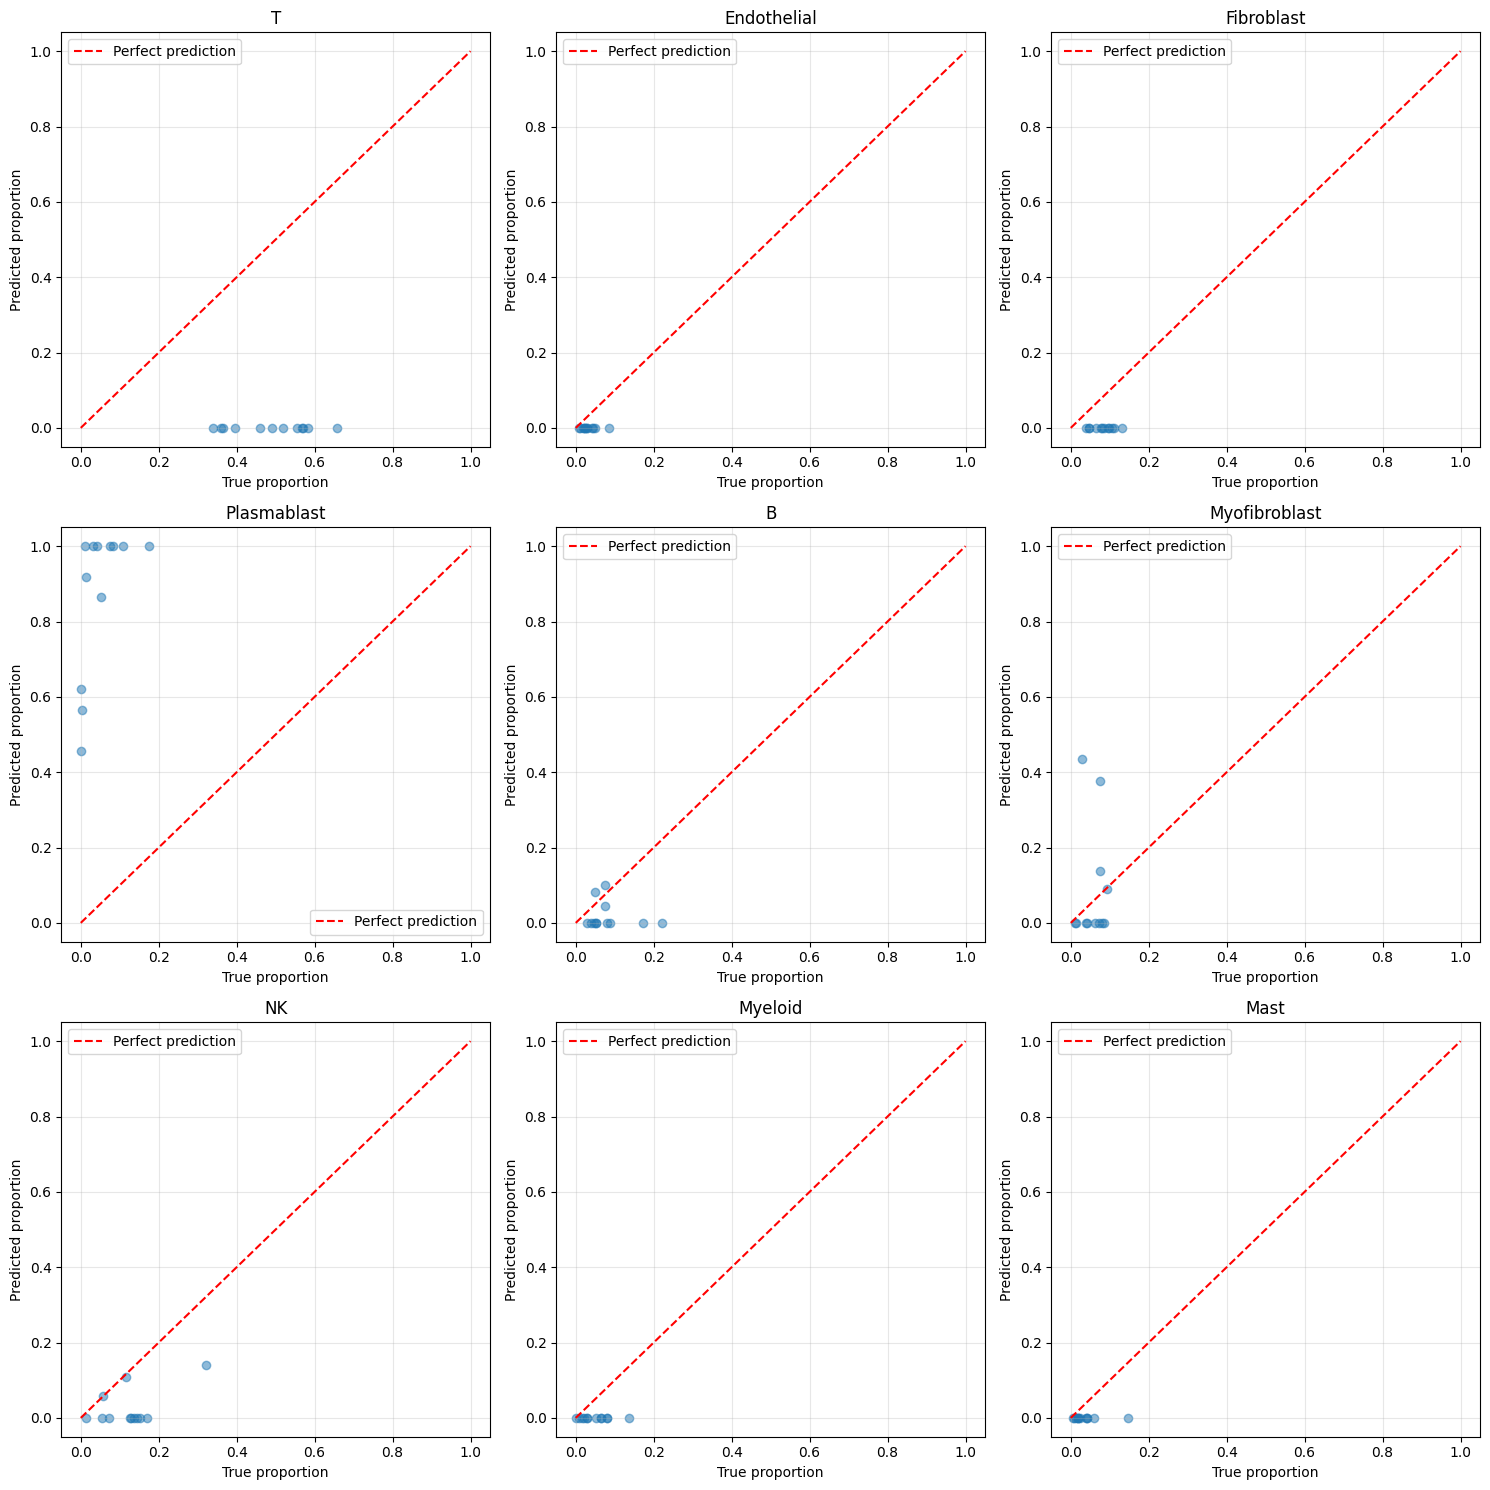

In [97]:
# Evaluate performance on training data
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def task_benchmark_score(true_props: pd.DataFrame, pred_props: pd.DataFrame):
    mae = (true_props.values - pred_props.values) ** 2
    print("Mae mean:", mae.mean(axis=1))
    return np.sqrt(mae.mean(axis=1).astype('float32')).mean()

def evaluate_deconvolution(true_props, pred_props):
    """Calculate performance metrics for deconvolution"""
    # Ensure same order
    common_samples = true_props.columns.intersection(pred_props.columns)
    common_celltypes = true_props.index.intersection(pred_props.index)
    
    true = true_props.loc[common_celltypes, common_samples]
    pred = pred_props.loc[common_celltypes, common_samples]
    
    mse = mean_squared_error(true.values.flatten(), pred.values.flatten())
    mae = mean_absolute_error(true.values.flatten(), pred.values.flatten())
    tb = task_benchmark_score(true, pred)
    rmse = np.sqrt(mse)
    
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Task Benchmark Score (TB): {tb:.4f}")
    
    # Per cell type performance
    print("\nPer-cell-type MAE:")
    for ct in common_celltypes:
        ct_mae = mean_absolute_error(true.loc[ct], pred.loc[ct])
        print(f"  {ct}: {ct_mae:.4f}")
    
    return mae, rmse

print("Evaluation on training data:")
evaluate_deconvolution(train_bulk_trueprops, train_props_pred)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, ct in enumerate(train_props_pred.index):
    ax = axes[idx]
    ax.scatter(train_bulk_trueprops.loc[ct], train_props_pred.loc[ct], alpha=0.5)
    ax.plot([0, 1], [0, 1], 'r--', label='Perfect prediction')
    ax.set_xlabel('True proportion')
    ax.set_ylabel('Predicted proportion')
    ax.set_title(f'{ct}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [19]:
# Deconvolve test bulk data
print("Deconvolving test bulk data...")
test_props_pred = deconvolve(test_bulk, gt_reference)
print(f"Test proportions shape: {test_props_pred.shape}")
test_props_pred = test_props_pred.reset_index()
print("\nTest predictions (first few samples):")
test_props_pred.iloc[:, :].head()

Deconvolving test bulk data...
Using 7725 common genes for deconvolution
Test proportions shape: (9, 20)

Test predictions (first few samples):


,index,s5_0,s5_1,s5_2,s5_3,s5_4,s6_0,s6_1,s6_2,s6_3,...,s9_0,s9_1,s9_2,s9_3,s9_4,s10_0,s10_1,s10_2,s10_3,s10_4
0,T,0.279966,0.544888,0.548547,0.512297,0.562389,0.528983,0.540306,0.569924,0.541547,...,0.548819,0.500886,0.523233,0.580755,0.552808,0.441331,0.458823,0.440578,0.484305,0.433373
1,Endothelial,0.075351,0.042401,0.045434,0.048386,0.044722,0.055161,0.050716,0.050235,0.051692,...,0.084177,0.085344,0.084915,0.082509,0.084970,0.091222,0.086951,0.089532,0.092615,0.085860
2,Fibroblast,0.040364,0.062921,0.057811,0.063758,0.055581,0.066115,0.067027,0.075322,0.075348,...,0.117207,0.084623,0.106356,0.107835,0.130922,0.070803,0.068018,0.068301,0.084765,0.069868
3,Plasmablast,0.036372,0.000471,0.016623,0.008442,0.007905,0.000986,0.001447,0.000920,0.000619,...,0.001891,0.002620,0.001094,0.003077,0.000006,0.003617,0.004429,0.007430,0.013719,0.000000
4,B,0.212112,0.259516,0.198993,0.210784,0.230070,0.266946,0.258459,0.210443,0.245071,...,0.197640,0.277858,0.213719,0.163223,0.165125,0.321258,0.313005,0.331877,0.224832,0.361210


# Step 2: Perform clustering 

In [20]:
# Preprocessing
sc.pp.filter_cells(train_adata, min_genes=200)
sc.pp.filter_genes(train_adata, min_cells=3)
sc_train_x = train_adata[train_adata.obs['pct_counts_mt'] < 10]

sc.pp.normalize_total(sc_train_x, target_sum=1e4)
sc.pp.log1p(sc_train_x)

sc.pp.highly_variable_genes(sc_train_x, n_top_genes=3000, batch_key="Sample")
sc_train_x = sc_train_x[:, sc_train_x.var['highly_variable']]

sc.pp.scale(sc_train_x, max_value=10)

/home/plaf/Documents/Scuola/ETH/master/3sem/ml4g/Genomics_2/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/plaf/Documents/Scuola/ETH/master/3sem/ml4g/Genomics_2/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/plaf/.local/share/uv/python/cpython-3.12.12-linux-x86_64-gnu/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [21]:
label_file = "data/train_data/sc_train_labels.npy"
if not os.path.exists(label_file):
    # replace with numbers (alphabetical order)
    labels = sc_train_x.obs['highLevelType'].unique()
    label_to_int = {lab: i for i, lab in enumerate(labels)}
    y = sc_train_x.obs['highLevelType'].map(label_to_int).astype(int).to_numpy()
    np.save(label_file, y)

sc_train_y = np.load(label_file)

In [22]:
def sc_cluster(sc_data):   
    sc.pp.neighbors(sc_data, use_rep='X_pca_harmony')
    sc.tl.leiden(sc_data, resolution=0.5)
    return sc_data

In [23]:
def sc_umap(sc_data):
    sc.tl.umap(sc_data, min_dist=0.3)
    sc.pl.umap(sc_data, color=['Sample', 'leiden'])

# Step 2bis: Predict on the test data

In [24]:
# SC pipeline
sc.pp.filter_genes(test_adata, min_cells=3)
sc.pp.normalize_total(test_adata, target_sum=1e4)
sc.pp.log1p(test_adata)
sc.pp.highly_variable_genes(test_adata, n_top_genes=2000, batch_key="Sample")
test_adata = test_adata[:, test_adata.var['highly_variable']]
sc.pp.scale(test_adata, max_value=10)

sc.tl.pca(test_adata, svd_solver='arpack')

ho = hm.run_harmony(test_adata.obsm['X_pca'], test_adata.obs, 'Sample')

test_adata.obsm['X_pca_harmony'] = ho.Z_corr.T

sc.pp.neighbors(test_adata, use_rep='X_pca_harmony')

sc.tl.leiden(test_adata, resolution=0.5)

/home/plaf/Documents/Scuola/ETH/master/3sem/ml4g/Genomics_2/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/plaf/.local/share/uv/python/cpython-3.12.12-linux-x86_64-gnu/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
2025-11-25 02:17:46,010 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-11-25 02:17:50,409 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-11-25 02:17:50,554 - harmonypy - INFO - Iteration 1 of 10
2025-11-25 02:17:58,789 - harmonypy - INFO - Iteration 2 of 10
2025-11-25 02:18:07,408 - harmonypy - INFO - Iteration 3 of 10
2025-11-25 02:18:19,763 - harmonypy - INFO - Iteration 4 of 10
2025-11-25 02:18:29,008 - harmonypy - INFO - Iteration 5 of 10
2025-11-25 02:18:40,108 - harmonypy - INFO - Converged after 5 iterations
/h

In [25]:
cluster_labels = test_adata.obs
cluster_labels = cluster_labels.reset_index()
cluster_labels = cluster_labels[['index', 'leiden']]
cluster_labels.rename(columns={'leiden': 'cluster'}, inplace=True)

# Step 3: Save the required files

In [26]:
assert len(test_props_pred.columns) == len(test_bulk.columns) + 1, "Length mismatch: expected {} but got {}".format(len(test_bulk.columns) + 1, len(test_props_pred.columns))
assert all(test_props_pred.columns == np.append(["index"], test_bulk.columns)), "Wrong columns"

In [27]:
assert all(test_props_pred['index']== ['T', 'Endothelial', 'Fibroblast', 'Plasmablast', 'B', 'Myofibroblast',
       'NK', 'Myeloid', 'Mast']), "Wrong order for cell types"

In [28]:
assert all(test_props_pred.drop("index",axis=1).sum().round()==1), "The proportions for a single patient must sum to 1"

In [29]:
# cluster_labels should be a DataFrame containing the cluster labels for each cell
# cluster_labels.columns = ["index", "cluster"]
# cluster_labels["index"] = test_adata.columns

In [30]:
assert all(cluster_labels.columns == ["index", "cluster"]), "Wrong columns"

In [31]:
assert all(cluster_labels["index"] == test_adata.obs_names), "The cell ids are either not all present or not in the right order"

In [32]:
import zipfile
from datetime import datetime
from dotenv import load_dotenv
load_dotenv()

from os import environ

first_name = environ.get('FIRST_NAME')
last_name = environ.get('LAST_NAME')
tstamp = datetime.now().strftime("%Y%m%d_%H%M%S")

results_path = pl.Path("data/submissions/")
archive_name = f"{tstamp}_{first_name}_{last_name}_Project2_submission.zip"

with zipfile.ZipFile(results_path / archive_name, "x") as zf:
    with zf.open(f"pred_props.csv", "w") as buffer:
        test_props_pred.to_csv(buffer)
    with zf.open(f"cluster_membership.csv", "w") as buffer:
        cluster_labels.to_csv(buffer)
    zf.close()

print(f"Submission archive saved to {results_path / archive_name}")

archive_name = f"{tstamp}_{first_name}_{last_name}_Project2_code.zip"

files_mapping = {
    "main.ipynb": "main.ipynb",
    "uv.lock": "uv.lock",
    ".python-version": ".python-version",
    "pyproject.toml": "pyproject.toml",
}

with zipfile.ZipFile(results_path / archive_name, "x") as zf:
    for fname, arcname in files_mapping.items():
        zf.write(fname, arcname)
    zf.close()

print(f"Code archive saved to {results_path / archive_name}")


Submission archive saved to data/submissions/20251125_021944_Paolo_Laffranchi_Project2_submission.zip
Code archive saved to data/submissions/20251125_021944_Paolo_Laffranchi_Project2_code.zip
